## Imports

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
import seaborn as sns

from tensorflow.keras.applications import EfficientNetB0


from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from scipy.stats import ks_2samp

In [ ]:
METRICS = [
    accuracy_score, recall_score, precision_score, f1_score
]

In [ ]:
BEST_MODEL_FOLDER = "/home/johan/Documents/UNIANDES/2023-I/MASTERING MACHINE LEARNING/"\
    "2_hparameter_exploration/logs/generator1__discriminator2__128/model"

In [ ]:
LABELS = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [ ]:
DATASET_FILE = "data/processed_data.h5"

In [ ]:
LATENT_DIM = 128
NUM_CLASS = 4
BATCH_SIZE = 32
RANDOM_STATE = 42
IMAGE_SIZE = 150
IMAGE_DEPTH = 3

In [ ]:
GAN_MODEL = tf.keras.models.load_model(BEST_MODEL_FOLDER, compile=False)

2023-07-26 20:00:22.319590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 20:00:22.364440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 20:00:22.364685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
def load_real_data():
    """loads real data from h5 file as numpy arrays"""
    with h5py.File(DATASET_FILE,'r+') as data:
        X_train = np.array(data["X_train"])
        X_test = np.array(data["X_test"])

        y_train = np.array(data["y_train"])
        y_test = np.array(data["y_test"])
    return X_train, X_test, y_train, y_test

In [ ]:
def generate_fake_train_dataset():
    """Generates fake tensorflow training dataset for classifier"""
    features = []
    labels = []
    train_label_count = dict(enumerate(y_train.sum(axis=0)))
    for label, count in tqdm(train_label_count.items()):
        one_hot_labels = tf.one_hot(
            [label for _ in range(count)],
            NUM_CLASS
        )
        labels.append(one_hot_labels)
        random_noise = tf.random.normal([count, LATENT_DIM])
        noise_labels = tf.data.Dataset.from_tensor_slices(
            tf.concat([random_noise, one_hot_labels], axis=1)
        ).batch(BATCH_SIZE)
        fake_images = []
        for batch in noise_labels:
            fake_images.append(
                GAN_MODEL(batch, training=False)
            )
        fake_images = tf.concat(fake_images, axis=0)
        features.append(fake_images)

    features = (tf.concat(features, axis=0).numpy() * 255).astype(int)
    labels = tf.concat(labels, axis=0).numpy()

    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)
    return features, labels

In [ ]:
def make_classifier():
    """Generates unfit classifier"""
    effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,IMAGE_DEPTH))

    model = effnet.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dropout(rate=0.5)(model)
    model = tf.keras.layers.Dense(4,activation='softmax')(model)
    model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

    model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

    return model

In [ ]:
def predict_large_dataset(model, dataset):
    batched_dataset = tf.data.Dataset.from_tensor_slices(
        dataset
    ).batch(BATCH_SIZE)
    return tf.concat(
        [tf.argmax(model(batch), axis=1) for batch in batched_dataset],
        axis=0
    )

In [ ]:
def calculate_prediction_metrics(y_true_hot, y_pred, split):
    """Generates a dataframe of predicted metrics"""
    y_true = y_true_hot.argmax(1)
    metrics = {}
    for metric in METRICS:
        try:
            metrics[metric.__name__] = [metric(y_true, y_pred)]
        except:
            pass
        for average in ["micro", "macro"]:
            try:
                metrics[f"{metric.__name__}__{average}"] = \
                    [metric(y_true, y_pred, average=average)]
            except:
                continue
    df_metrics = pd.DataFrame(metrics)
    df_metrics["split"] = split

    return df_metrics

In [ ]:
def calculate_experiment_metrics(y_train_true, y_test_true, y_train_pred, y_test_pred, data_type):
    df_train_metrics = calculate_prediction_metrics(y_train_true, y_train_pred, "train")
    df_test_metrics = calculate_prediction_metrics(y_test_true, y_test_pred, "test")
    df_metrics = pd.concat([df_train_metrics, df_test_metrics]).reset_index(drop=True)
    df_metrics["data_type"] = data_type
    return df_metrics

In [ ]:
X_train, X_test, y_train, y_test = load_real_data()

/tmp/ipykernel_29931/4208548737.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  X_train = np.array(data["X_train"])
/tmp/ipykernel_29931/4208548737.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  X_test = np.array(data["X_test"])
/tmp/ipykernel_29931/4208548737.py:7: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  y_train = np.array(data["y_train"])
/tmp/ipykernel_29931/4208548737.py:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  y_test = np.array(data["y_test"])


In [ ]:
fake_train, fake_labels = generate_fake_train_dataset()

  0%|                                                     | 0/4 [00:00<?, ?it/s]2023-07-26 20:00:23.072551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-07-26 20:00:23.096081: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


In [ ]:
base_classifier = make_classifier()
fake_classifier = make_classifier()
mixed_classifier = make_classifier()

In [ ]:
base_history = base_classifier.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=12,
    verbose=1,
    batch_size=BATCH_SIZE
)

Epoch 1/12


2023-07-26 20:00:36.827342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-07-26 20:00:38.039147: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa79801d160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-26 20:00:38.039171: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-07-26 20:00:38.042988: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-26 20:00:38.089552: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-26 20:00:38.133370: I ./tensorflow/compiler/jit/d

83/83 [==============================] - 29s 83ms/step - loss: 0.4606 - accuracy: 0.8339 - val_loss: 0.8619 - val_accuracy: 0.7959
Epoch 2/12
83/83 [==============================] - 5s 63ms/step - loss: 0.2001 - accuracy: 0.9311 - val_loss: 0.2437 - val_accuracy: 0.9252
Epoch 3/12
83/83 [==============================] - 5s 63ms/step - loss: 0.1309 - accuracy: 0.9591 - val_loss: 0.1886 - val_accuracy: 0.9456
Epoch 4/12
83/83 [==============================] - 5s 63ms/step - loss: 0.0739 - accuracy: 0.9769 - val_loss: 0.3101 - val_accuracy: 0.9218
Epoch 5/12
83/83 [==============================] - 5s 63ms/step - loss: 0.0669 - accuracy: 0.9807 - val_loss: 0.1800 - val_accuracy: 0.9422
Epoch 6/12
83/83 [==============================] - 5s 63ms/step - loss: 0.0586 - accuracy: 0.9845 - val_loss: 0.1436 - val_accuracy: 0.9626
Epoch 7/12
83/83 [==============================] - 5s 62ms/step - loss: 0.0520 - accuracy: 0.9860 - val_loss: 0.3136 - val_accuracy: 0.9388
Epoch 8/12
83/83 [=====

In [ ]:
fake_history = fake_classifier.fit(
    fake_train,
    fake_labels,
    validation_split=0.1,
    epochs=12,
    verbose=1,
    batch_size=BATCH_SIZE
)

Epoch 1/12


2023-07-26 20:02:04.570595: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


83/83 [==============================] - 26s 76ms/step - loss: 0.6905 - accuracy: 0.7246 - val_loss: 3.0523 - val_accuracy: 0.4150
Epoch 2/12
83/83 [==============================] - 6s 67ms/step - loss: 0.2622 - accuracy: 0.9039 - val_loss: 0.5381 - val_accuracy: 0.8401
Epoch 3/12
83/83 [==============================] - 6s 67ms/step - loss: 0.1519 - accuracy: 0.9470 - val_loss: 0.8875 - val_accuracy: 0.7075
Epoch 4/12
83/83 [==============================] - 6s 67ms/step - loss: 0.0765 - accuracy: 0.9728 - val_loss: 0.7547 - val_accuracy: 0.7993
Epoch 5/12
83/83 [==============================] - 5s 65ms/step - loss: 0.0817 - accuracy: 0.9720 - val_loss: 0.8242 - val_accuracy: 0.8231
Epoch 6/12
83/83 [==============================] - 6s 67ms/step - loss: 0.0930 - accuracy: 0.9686 - val_loss: 0.4718 - val_accuracy: 0.8469
Epoch 7/12
83/83 [==============================] - 6s 67ms/step - loss: 0.0482 - accuracy: 0.9818 - val_loss: 0.2941 - val_accuracy: 0.9048
Epoch 8/12
83/83 [=====

In [ ]:
mixed_train = tf.concat(
    [fake_train, X_train],
    axis=0
).numpy()
mixed_labels = tf.concat(
    [fake_labels, y_train],
    axis=0
).numpy()

mixed_train, mixed_labels = shuffle(mixed_train, mixed_labels, random_state=RANDOM_STATE)

In [ ]:
mixed_history = mixed_classifier.fit(
    mixed_train,
    mixed_labels,
    validation_split=0.1,
    epochs=12,
    verbose=1,
    batch_size=BATCH_SIZE
)

Epoch 1/12


2023-07-26 20:03:36.820456: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


166/166 [==============================] - 33s 75ms/step - loss: 0.6095 - accuracy: 0.7635 - val_loss: 0.5733 - val_accuracy: 0.8044
Epoch 2/12
166/166 [==============================] - 11s 67ms/step - loss: 0.3006 - accuracy: 0.8857 - val_loss: 0.4569 - val_accuracy: 0.8282
Epoch 3/12
166/166 [==============================] - 11s 67ms/step - loss: 0.1979 - accuracy: 0.9274 - val_loss: 0.3999 - val_accuracy: 0.8707
Epoch 4/12
166/166 [==============================] - 11s 67ms/step - loss: 0.1465 - accuracy: 0.9527 - val_loss: 0.3032 - val_accuracy: 0.9065
Epoch 5/12
166/166 [==============================] - 11s 67ms/step - loss: 0.0932 - accuracy: 0.9678 - val_loss: 0.3616 - val_accuracy: 0.9014
Epoch 6/12
166/166 [==============================] - 11s 67ms/step - loss: 0.1007 - accuracy: 0.9654 - val_loss: 0.3032 - val_accuracy: 0.9252
Epoch 7/12
166/166 [==============================] - 11s 67ms/step - loss: 0.0740 - accuracy: 0.9731 - val_loss: 0.2387 - val_accuracy: 0.9235
Epo

In [ ]:
base_train_pred = predict_large_dataset(base_classifier, X_train)
fake_train_pred = predict_large_dataset(fake_classifier, fake_train)
mixed_train_pred = predict_large_dataset(mixed_classifier, mixed_train)

In [ ]:
base_test_pred = predict_large_dataset(base_classifier, X_test)
fake_test_pred = predict_large_dataset(fake_classifier, X_test)
mixed_test_pred = predict_large_dataset(mixed_classifier, X_test)

In [ ]:
base_metrics = calculate_experiment_metrics(
    y_train,
    y_test,
    base_train_pred,
    base_test_pred,
    "baseline"
)
base_metrics

,accuracy_score,recall_score__micro,recall_score__macro,precision_score__micro,precision_score__macro,f1_score__micro,f1_score__macro,split,data_type
0,0.993531,0.993531,0.994334,0.993531,0.994046,0.993531,0.994170,train,baseline
1,0.963303,0.963303,0.968498,0.963303,0.965427,0.963303,0.966452,test,baseline


In [ ]:
fake_metrics = calculate_experiment_metrics(
    fake_labels,
    y_test,
    fake_train_pred,
    fake_test_pred,
    "generated"
)
fake_metrics

,accuracy_score,recall_score__micro,recall_score__macro,precision_score__micro,precision_score__macro,f1_score__micro,f1_score__macro,split,data_type
0,0.986721,0.986721,0.987813,0.986721,0.988114,0.986721,0.987826,train,generated
1,0.446483,0.446483,0.484022,0.446483,0.509142,0.446483,0.407214,test,generated


In [ ]:
mixed_metrics = calculate_experiment_metrics(
    mixed_labels,
    y_test,
    mixed_train_pred,
    mixed_test_pred,
    "mixed"
)
mixed_metrics

,accuracy_score,recall_score__micro,recall_score__macro,precision_score__micro,precision_score__macro,f1_score__micro,f1_score__macro,split,data_type
0,0.979571,0.979571,0.979197,0.979571,0.981564,0.979571,0.98020,train,mixed
1,0.935780,0.935780,0.940297,0.935780,0.942565,0.935780,0.93953,test,mixed


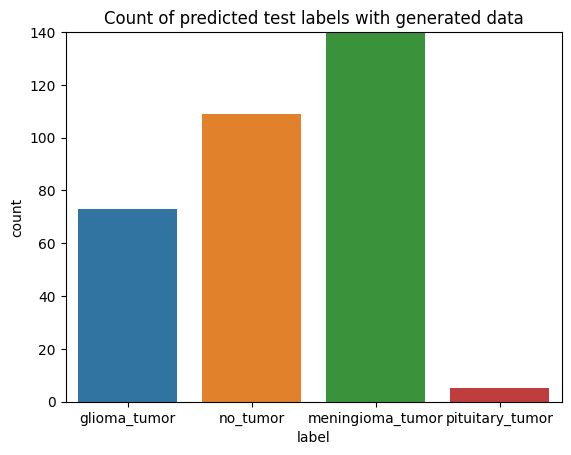

In [ ]:
plt.title("Count of predicted test labels with generated data")
df_fake_test_pred_count = pd.value_counts(fake_test_pred.numpy()).to_frame(name="count").reset_index()
df_fake_test_pred_count.rename(columns={"index":"label"}, inplace=True)
sns.barplot(df_fake_test_pred_count, x="label", y="count")
ax = plt.gca()
ax.set_xticklabels(LABELS)
ax.set_ylim(0,140)
plt.show()

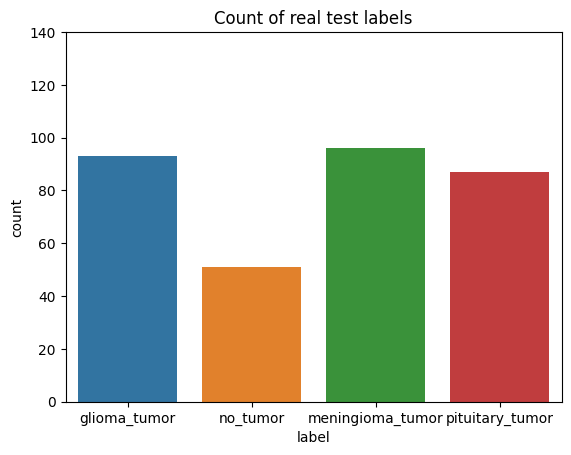

In [ ]:
plt.title("Count of real test labels")
df_fake_test_pred_count = pd.value_counts(y_test.argmax(1)).to_frame(name="count").reset_index()
df_fake_test_pred_count.rename(columns={"index":"label"}, inplace=True)
sns.barplot(df_fake_test_pred_count, x="label", y="count")
ax = plt.gca()
ax.set_xticklabels(LABELS)
ax.set_ylim(0,140)
plt.show()

In [ ]:
def plot_color_dists(real_images, fake_images):
    flatten_real_colors = [
        real_images[:,:,:,i].flatten() for i in range(3)
    ]
    flatten_fake_colors = [
        fake_images[:,:,:,i].flatten() for i in range(3)
    ]
    fig, axs = plt.subplots(3, figsize=(10,5))
    plt.suptitle("Comparison of color distribution")
    fig.tight_layout()
    colors = ["Red", "Green", "Blue"]
    for i in range(3):
        ks = ks_2samp(flatten_real_colors[i], flatten_fake_colors[i])
        axs[i].set_title(f"Channel - {colors[i]}, ks={ks.statistic}", fontsize=10, loc="right")
        axs[i].hist(flatten_real_colors[i], color="blue", alpha=0.3, label=f"real", bins=60)
        axs[i].hist(flatten_fake_colors[i], color="yellow", alpha=0.3, label=f"generated", bins=60)
    plt.legend(loc='center left')
    plt.show()

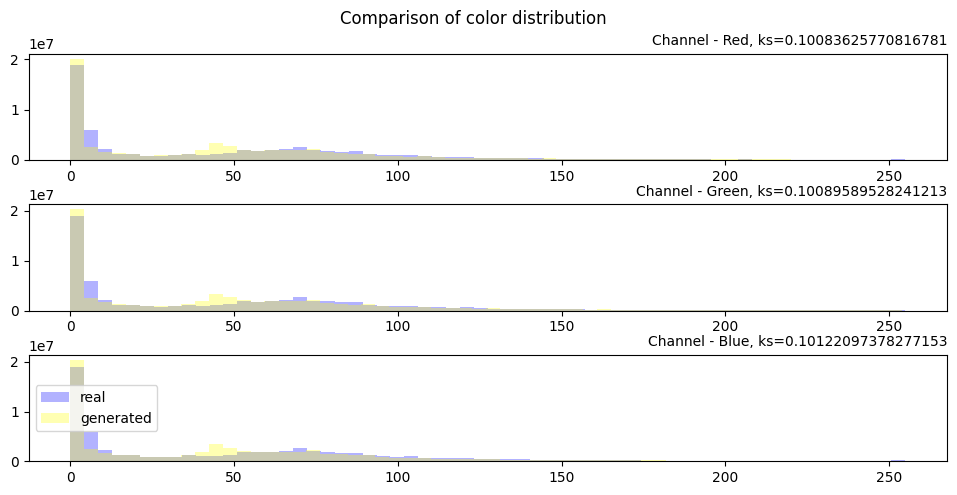

In [ ]:
plot_color_dists(X_train, fake_train)